<a href="https://colab.research.google.com/github/Vincent-Attakpah/Weather-Analysis-with-RF/blob/main/Weather-Analysis-with-RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import openmeteo_requests

import requests_cache
from retry_requests import retry

!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [32]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2010-01-01",
	"end_date": "2024-12-20",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()
daily_apparent_temperature_mean = daily.Variables(6).ValuesAsNumpy()
daily_sunrise = daily.Variables(7).ValuesAsNumpy()
daily_sunset = daily.Variables(8).ValuesAsNumpy()
daily_daylight_duration = daily.Variables(9).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(10).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(11).ValuesAsNumpy()
daily_rain_sum = daily.Variables(12).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(13).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(14).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(15).ValuesAsNumpy()
daily_wind_gusts_10m_max = daily.Variables(16).ValuesAsNumpy()
daily_wind_direction_10m_dominant = daily.Variables(17).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(18).ValuesAsNumpy()
daily_et0_fao_evapotranspiration = daily.Variables(19).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["weather_code"] = daily_weather_code
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
daily_data["sunrise"] = daily_sunrise
daily_data["sunset"] = daily_sunset
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["sunshine_duration"] = daily_sunshine_duration
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum
daily_data["precipitation_hours"] = daily_precipitation_hours
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum
daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration

df = pd.DataFrame(data = daily_data)
print(df)


Coordinates 52.5483283996582°N 13.407821655273438°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                          date  weather_code  temperature_2m_max  \
0    2010-01-01 00:00:00+00:00          73.0           -1.611000   
1    2010-01-02 00:00:00+00:00          71.0           -1.211000   
2    2010-01-03 00:00:00+00:00          71.0           -4.861000   
3    2010-01-04 00:00:00+00:00           3.0           -6.311000   
4    2010-01-05 00:00:00+00:00           3.0           -5.411000   
...                        ...           ...                 ...   
5463 2024-12-16 00:00:00+00:00          51.0           10.658501   
5464 2024-12-17 00:00:00+00:00          51.0            9.608500   
5465 2024-12-18 00:00:00+00:00          51.0           11.358500   
5466 2024-12-19 00:00:00+00:00          61.0           13.058500   
5467 2024-12-20 00:00:00+00:00          51.0            6.058500   

      temperature_2m_min  temperature_2m_mean  apparent_te

In [35]:
print("Dataset Overview:")
print(df.head())  # Display the first few rows
print("\nSummary:")
print(df.info())  # Overview of columns, data types, and missing values
print("\nStatistics:")
print(df.describe())  # Summary statistics for numerical features

Dataset Overview:
                       date  weather_code  temperature_2m_max  \
0 2010-01-01 00:00:00+00:00          73.0              -1.611   
1 2010-01-02 00:00:00+00:00          71.0              -1.211   
2 2010-01-03 00:00:00+00:00          71.0              -4.861   
3 2010-01-04 00:00:00+00:00           3.0              -6.311   
4 2010-01-05 00:00:00+00:00           3.0              -5.411   

   temperature_2m_min  temperature_2m_mean  apparent_temperature_max  \
0           -3.161000            -2.527666                 -6.319958   
1           -5.711000            -3.292250                 -5.653913   
2           -8.811001            -6.752668                 -8.793984   
3           -9.511001            -7.671417                -10.819073   
4          -11.711000            -7.873501                 -9.848407   

   apparent_temperature_min  apparent_temperature_mean  sunrise  sunset  ...  \
0                 -7.746176                  -7.153605        0       0  ...  

In [38]:
# Drop irrelevant columns
df_cleaned = df.drop(columns=['sunrise', 'sunset'])

# Extract time-based features from the 'date' column
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
df_cleaned['year'] = df_cleaned['date'].dt.year
df_cleaned['month'] = df_cleaned['date'].dt.month
df_cleaned['day'] = df_cleaned['date'].dt.day
df_cleaned['day_of_week'] = df_cleaned['date'].dt.dayofweek
df_cleaned['is_weekend'] = df_cleaned['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Drop the original 'date' column
df_cleaned = df_cleaned.drop(columns=['date'])

# Normalize numerical features
scaler = StandardScaler()
numerical_features = df_cleaned.select_dtypes(include=['float32', 'int64']).columns
df_cleaned[numerical_features] = scaler.fit_transform(df_cleaned[numerical_features])

# Display the cleaned data
print("Cleaned Data:")
print(df_cleaned.head())


Cleaned Data:
   weather_code  temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
0      1.434374           -1.810790           -1.389536            -1.667915   
1      1.361473           -1.765296           -1.751350            -1.765475   
2      1.361473           -2.180426           -2.191202            -2.207019   
3     -1.117135           -2.345340           -2.290523            -2.324249   
4     -1.117135           -2.242979           -2.602676            -2.350035   

   apparent_temperature_max  apparent_temperature_min  \
0                 -1.756513                 -1.365080   
1                 -1.691766                 -1.662756   
2                 -1.997016                 -1.936973   
3                 -2.193876                 -2.061356   
4                 -2.099517                 -2.362351   

   apparent_temperature_mean  daylight_duration  sunshine_duration  \
0                  -1.612153          -1.452000          -1.539461   
1                  -1.

In [40]:
# Define features (X) and target variable (y)
# Replace 'temperature_2m_max' with your target column
target_column = 'temperature_2m_max'
X = df_cleaned.drop(columns=[target_column])
y = df_cleaned[target_column]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (4374, 22)
Testing set size: (1094, 22)


In [42]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Random Forest Regressor Performance:
Mean Squared Error (MSE): 0.00
Mean Absolute Error (MAE): 0.05
R² Score: 1.00


In [45]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5, scoring='r2', verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Train the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_rf_model.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("Tuned Random Forest Performance:")
print(f"Mean Squared Error (MSE): {mse_tuned:.2f}")
print(f"Mean Absolute Error (MAE): {mae_tuned:.2f}")
print(f"R² Score: {r2_tuned:.2f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   6.1s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   4.2s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   4.2s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   9.8s
[CV] END max_depth=10, min_samples_split=2, n_e

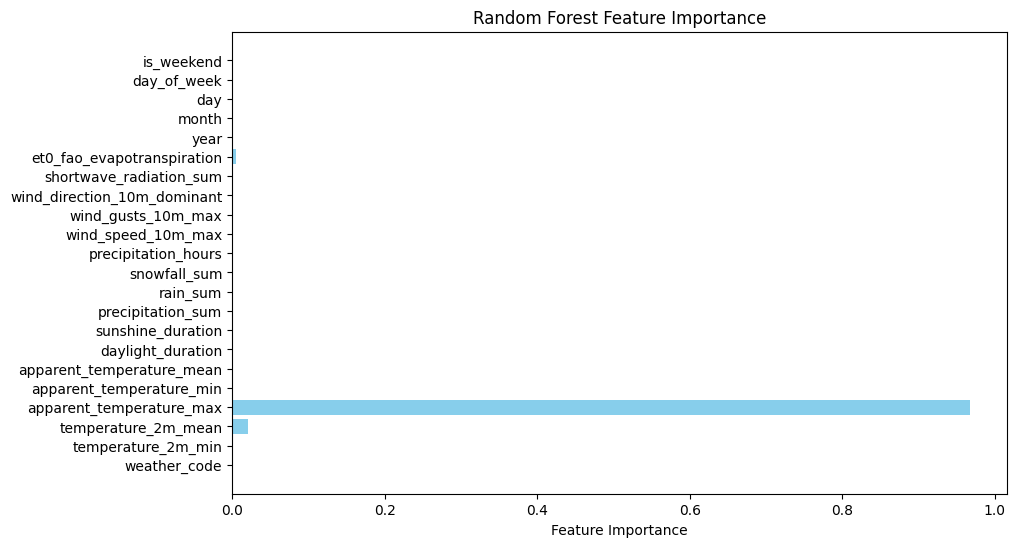

In [46]:
# Feature importance
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()